### Fisher Forecast with velocity angular power spectrum of Type Ia supernovae

In this notebook we will obtain a Fisher matrix by autodiff with jax-cosmo

In [2]:
%matplotlib inline 
import jax
import jax_cosmo as jc
import jax.numpy as np # any numpy function will be JAX-accelerted and differentiable
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd

#### Functions

In [3]:
#plotting function

def plot_contours(fisher, pos, nstd=1., ax=None, **kwargs):
    """"
    Plot 2D parameter contours given a Hessian matrix of the likelihood
    """
    
    def eigsorted(cov):
        vals, vecs = linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:, order]

    mat = fisher
    cov = np.linalg.inv(mat)
    sigma_marg = lambda i: jnp.sqrt(cov[i, i])

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

    # Width and height are "full" widths, not redius
    width, height = 2 * nstd * sqrt(vals)
    ellip = Ellipse(xy=pos, width=width,
                        height=height, angle=theta, **kwargs)
    
    ax.add_artist(ellip)
    sz = max(width, height)
    s1 = 1.5 * nstd * sigma_marg(0)
    s2 = 1.5 * nstd * sigma_marg(1)
    ax.set_xlim(pos[0] - s1, pos[0] + s1)
    ax.set_ylim(pos[0] - s2, pos[1] + s2)
    plt.draw()
    return ellip

#### Redshit Distribution

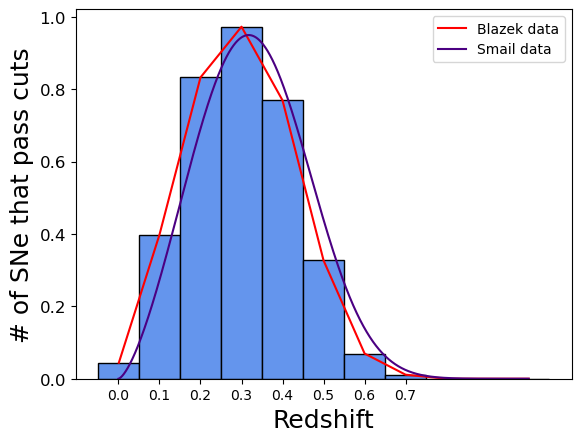

In [36]:
#open file

# FIXME: add file to local repository (?) 
# Path on my mac
data = pd.read_csv('/Users/joaopedrobonifacio/Documents/lib/python/Peculiar_Velocities_Cells/z_distribution.csv', sep=',', header=0)

#Path on OV
#arquivo = open('/home/joao/lib/python/Peculiar_Velocities_Cells/z_distribution.csv', 'r')
#data = pd.read_csv(arquivo, sep=',', header=0)

z =[]
spec_SNe =[]

for i in data:
    z.append(data['z'])
    spec_SNe.append(data['spec_SNe'])

z = np.array(z[0])
spec_SNe = np.array(spec_SNe[0])

# Using smail_nz to reproduce the Blazek's data
zz = np.linspace(0., 1., 10000)
nz = jc.redshift.smail_nz(1.5, 3, 0.4)

#plt.figure(figsize=(12, 12))
plt.bar(z, spec_SNe/100000, color='cornflowerblue', alpha=1, width=0.1, edgecolor='k')
plt.plot(z, spec_SNe/100000, color='red', label = 'Blazek data')
plt.plot(zz, nz(zz)/3, color = 'indigo', linewidth=1.5, label='Smail data')
plt.xticks([0, .1, .2, .3, .4, .5, .6, .7])
#plt.xlim(0, 0.8)
plt.yticks(fontsize=12)
#plt.yscale('log')
plt.xlabel('Redshift', fontsize=18)
plt.ylabel('# of SNe that pass cuts', fontsize=18)
plt.legend()

#### Difining Probes and computing Cells

We want to define velocity probes using the z distribution above.
In jax-cosmo a probe/tracer of a given type contains a series of parameters.
Probes are hosted in the jax_cosmo.probes module. 

Cells computations will take as argument a list of probes and will compute auto- and cross- correlations between all redshift bins of all probes.

In [18]:
probe = jc.probes.P


AttributeError: module 'jax_cosmo.probes' has no attribute 'PeculiarVelocity'

Given these probes, we can compute tomographic angular power spectra for these probes using the angular_cl tools hosted in the jax_cosmo.angular_cl module.
All computations are done under the Limber approximation

In [ ]:
# Defines a range of ells
ell = np.logspace(1, 3) 

# Compute the data vector
cls = jc.angular_cl.angular_cl(cosmo, ell, probes)

#### Fisher Matrix 

Begin by defining a Gaussian Likelihood function for the data vector we have obtained and makes this likelihood function depend on an array of parameters, Omega_c and sigma_8 

In [ ]:
# Creation of fake data from fiduncial cosmology
params = jnp.array([cosmology.Omega_c, cosmology.sigma8])

@jax.jit # Makes the code run fast on GPU
def likelihood(p):
    # Creates a new cosmology at these parameters
    cosmology = jc.Planck15(Omega_c=p[0], sigma8=[1]) 

    # Compute mean and covariance of Cells
    mean, Covariance = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmology, ell, probes, sparse=True)

    # Return likelihood value assuming constant covariance, so we stop the gradient at the
    # level of precision matrix, and we will not include the logdet term in the likelihood.
    P = jc.sparse.inv(jax.lax.stop_gradient(Covariance))
    r = data - mean
    return -0.5 * r.T @ jc.sparse.sparse_dot_vec(P, r) 

Now that we have a likelihood function of the parameters we can manipulate it woth JAX and in particular take the second derivative of this likelihood with respect to the input cosmological parameters. This Hessian, is just minus the Fisher matrix when everything is Gaussian around the fiduncial cosmology.

JAX autodiff - we can analytically derive the Fisher matrix in just one line.

In [ ]:
# Compile a function that computes the Hessian of the likelihood
hessian_loglike = jax.jit(jax.hessian(likelihood))

# Evaluate the Hessian at fiduncial cosmology to retrieve Fisher matrix
F = - hessian_loglike(params)

In [ ]:
# Plot the contours obtained
plot_contours(F, params, fill=False);
xlabel('Omega_m')
ylabel('sigma8')